## Libraries & Packages

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score



## Load Data

In [2]:
# gervasio file_path
g_path = r"C:\Users\gerva\OneDrive\Documentos\GitHub\ST498_CAPSTONE\FLASH\toShare"

In [5]:
# shruti


In [3]:
# fin
fin_path = "/Users/finbarrhodes/Documents/Github/ST498_CAPSTONE/FLASH/toShare"

In [181]:
control_file_name = "/controlePreConsolide.csv"
control_csv_path = fin_path + control_file_name
df_control = pd.read_csv(control_csv_path)

int_file_name = "/interventionPreConsolide.csv"
int_csv_path = fin_path + int_file_name
df_int = pd.read_csv(int_csv_path)

combined_groups = pd.concat([df_control, df_int])

In [200]:
len(df_control)

17314

In [217]:
abc = pd.Index([1, 2, 3, 4, 5, 6, 7])
de = pd.Index([1, 2, 3])

de.difference(abc)

Index([], dtype='int64')

In [212]:
len(df_control['Unnamed: 0'].unique()) == len(df_control)
len(df_int['Unnamed: 0'].unique()) == len(df_int)

control_timestamps = pd.Index(df_control['Unnamed: 0'])
int_timestamps = pd.Index(df_int['Unnamed: 0'])

in_intervention_not_control = control_timestamps.difference(int_timestamps)
# 99 timestamps in intervention that are missing from control

in_control_not_intervention = int_timestamps.difference(control_timestamps)
# 156 timestamps in control that are missing from intervention 

# results in 57 row differential in df_control and df_int

# solution is to preprocess them separately and then combine them once we get IDs as rows and HH interval averages as columns

In [233]:
socio_file = r"/socioEcodata.csv"
socio_csv_path = fin_path + socio_file
df_socio = pd.read_csv(socio_csv_path)

## Generic Data comments:
1. Socioeconomic info for 1138 IDs with a total of 18 columns
2. ControlConsolide has 11420 half-hour readings for 506 IDs
3. Socioeconomic has no repeated features nor IDs
4. In ControlConsolide, 487 / 506 IDs dhave socioeconomic features
5. The timeframe of ControlConsolide is 2024-04-01 to 2024-12-31


In [234]:
print("Pre-Control Data:", df_control.shape)
print("Pre-Intervention Data:", df_int.shape)
print("Socioeconomic Data:", df_socio.shape)

Pre-Control Data: (17314, 321)
Pre-Intervention Data: (17371, 388)
Socioeconomic Data: (1138, 18)


In [235]:
df_socio.columns

Index(['HASH_KEY', 'AGE_GROUP', 'INCOME_CATEGORY', 'HOUSEHOLD_OCCUPANCY',
       'CHILDREN_AT_HOME', 'HOUSEHOLD_SIZE', 'NUMBER_OF_BEDROOMS',
       'OCCUPATION', 'EMPLOYMENT_STATUS', 'HIGHEST_QUALIFICATION',
       'HOME_OWNERSHIP', 'HOME_TYPE', 'HOME_VALUE', 'SOCIAL_GRADE',
       'TARIFF_GROUP', 'ESTIMATED_CONSUMPTION_ELEC_DAY',
       'ESTIMATED_CONSUMPTION_ELEC_NIGHT', 'ESTIMATED_CONSUMPTION_TOTAL'],
      dtype='object')

In [236]:
df_socio.head()

,HASH_KEY,AGE_GROUP,INCOME_CATEGORY,HOUSEHOLD_OCCUPANCY,CHILDREN_AT_HOME,HOUSEHOLD_SIZE,NUMBER_OF_BEDROOMS,OCCUPATION,EMPLOYMENT_STATUS,HIGHEST_QUALIFICATION,HOME_OWNERSHIP,HOME_TYPE,HOME_VALUE,SOCIAL_GRADE,TARIFF_GROUP,ESTIMATED_CONSUMPTION_ELEC_DAY,ESTIMATED_CONSUMPTION_ELEC_NIGHT,ESTIMATED_CONSUMPTION_TOTAL
0,8399087eaac9d88e3c6fce0c76484d18a40576c2fd46b7...,35-44,"50,000-74,999",Couple Household,0,2,3,Professional,Employed,University Degree or Higher,Owner Occupied,Semi-Detached House,250-500k,Social grade B,Deemed,2088,0,2088
1,b2d78d29b401e989873368a90f4079ba17bf5448db4c73...,65-74,"30,000-39,999",Couple Household,0,2,3,Retired,Not Employed,A Level Equivalent,Owner Occupied,Semi-Detached House,250-500k,Social grade C1,EDF Essentials,2422,0,2422
2,dc1ec3fca1531822856b50fabe334a17a6053dccb66498...,55-64,"0-9,999",Single Adult Household,0,1,1,Director/Managerial,Employed,University Degree or Higher,Owner Occupied,Flat or Maisonette,250-500k,Social grade C1,Safeguard Assist,1374,0,1374
3,cd68542ea1a700c995074c15c8f41973443359a9bbff2a...,75+,"20,000-29,999",Single Adult Household,0,1,1,Retired,Not Employed,University Degree or Higher,Owner Occupied,Flat or Maisonette,250-500k,Social grade C1,EDF Essentials,2619,0,2619
4,fef90b0143496f6e158ba9db416049340d590648659fc6...,55-64,"100,000+",Couple Household,0,2,4,Professional,Employed,University Degree or Higher,Owner Occupied,Detached House,250-500k,Social grade B,Standard,5504,0,5504


In [251]:
cols_control = df_control.columns
control_common_keys = df_socio['HASH_KEY'].isin(cols_control)
print(f"Number of matching entries in control: {control_common_keys.sum()} out of {len(cols_control)} ({round(control_common_keys.sum() / len(cols_control) * 100, 2)}%)")

cols_int = df_int.columns
int_common_keys = df_socio['HASH_KEY'].isin(cols_int)
print(f"Number of matching entries in control: {int_common_keys.sum()} out of {len(cols_int)} ({round(int_common_keys.sum() / len(cols_int) * 100, 2)}%)")

Number of matching entries in control: 313 out of 321 (97.51%)
Number of matching entries in control: 372 out of 388 (95.88%)


In [252]:
# Count the number of duplicate HASH_KEY values
duplicate_counts = df_socio['HASH_KEY'].duplicated().sum()
print(f"Number of duplicate HASH_KEY entries: {duplicate_counts}")

Number of duplicate HASH_KEY entries: 0


In [253]:
# Get all column names from df_control
cols_control_consolide = set(df_control.columns)

# Check which columns are NOT in df_socio['HASH_KEY']
missing_cols = cols_control_consolide - set(df_socio['HASH_KEY'])

print("Columns in df_control that are NOT in df_socio['HASH_KEY']:")
print(missing_cols)


Columns in df_control that are NOT in df_socio['HASH_KEY']:
{'6dde0e5269f557dc5530f5107a9ad925b7fafc6a52d4f6fef834a0e23fd8b63c', '018e0c5cf686da1b7ac2d170d54aba9263fdc420b65ff5e71d4539e926385772', 'ab48a3a3cca4eedbb8d6317c4e02de2523ecaa866117a0672aa989fa830ba52a', 'Unnamed: 0', '0a67e7537bf618ab4f6983665d02d2cba69773971926d22c411678814d730ff0', 'bbd37f115949e74f97d7fbb407e3ed505bc179507d744340dace2d71a5813950', '585675d4b905182ed7cee11a72597a682fbca36da153f6116fec806cf96ab0d5', 'd4a27dd49c8bf8270dff2411f456287af4ad6d0fd86889506362b9fd13f86e87'}


## EDA

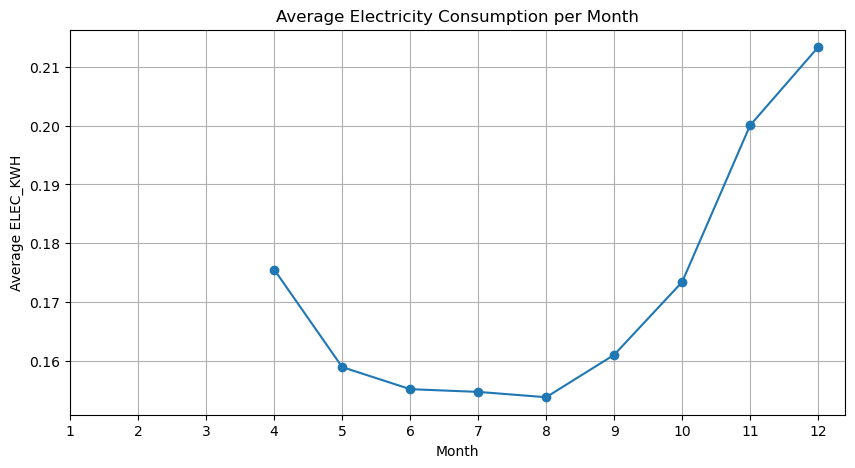

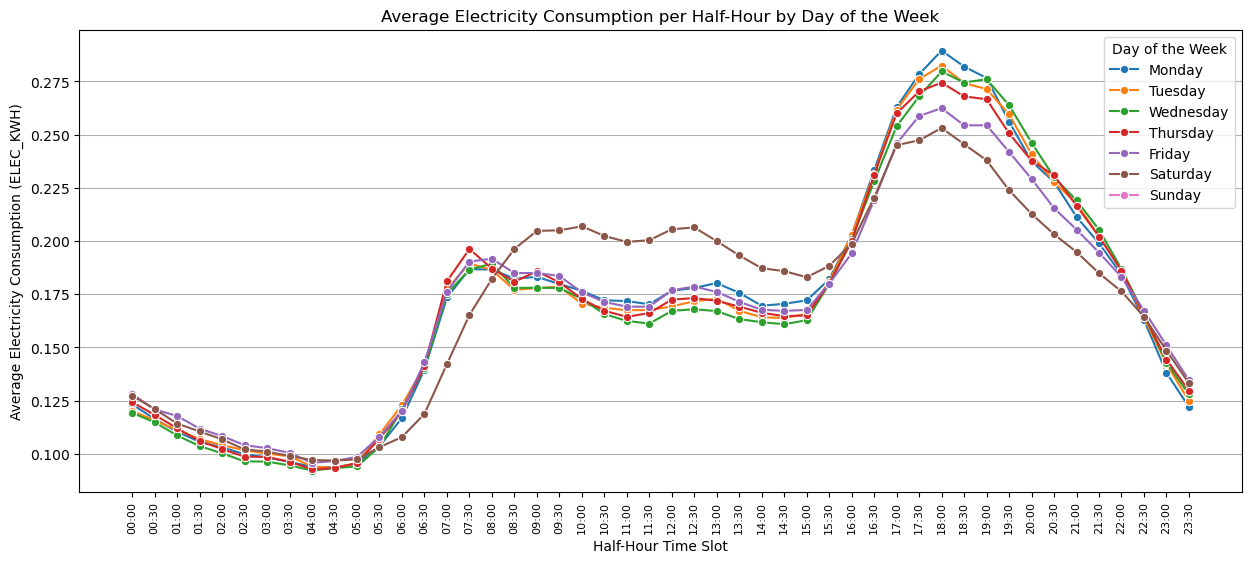

<Figure size 1500x600 with 0 Axes>

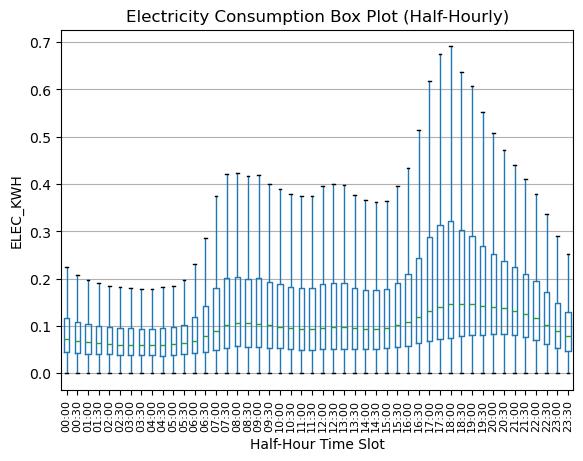

In [19]:
df_control = df_control.rename(columns={'Unnamed: 0': 'Time'})
df_control['Time'] = pd.to_datetime(df_control['Time'])

# Unpivot (melt) the dataset: Convert wide format to long format
df_control_long = df_control.melt(id_vars=['Time'], var_name='ID', value_name='ELEC_KWH')
df_control_long['Month'] = df_control_long['Time'].dt.month
df_control_long['DayOfWeek'] = df_control_long['Time'].dt.day_name()
df_control_long['HalfHour'] = df_control_long['Time'].dt.strftime('%H:%M')  # Captures half-hourly reading format


## 1. Plot: Average Consumption Across Months
monthly_avg = df_control_long.groupby('Month')['ELEC_KWH'].mean()

plt.figure(figsize=(10,5))
plt.plot(monthly_avg.index, monthly_avg.values, marker='o', linestyle='-')
plt.xlabel('Month')
plt.ylabel('Average ELEC_KWH')
plt.title('Average Electricity Consumption per Month')
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()


# Compute the average ELEC_KWH for each HalfHour and DayOfWeek across all IDs
df_avg_halfhour = df_control_long.groupby(['HalfHour', 'DayOfWeek'])['ELEC_KWH'].mean().reset_index()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_avg_halfhour['DayOfWeek'] = pd.Categorical(df_avg_halfhour['DayOfWeek'], categories=day_order, ordered=True)

# Plot: Line chart for average electricity consumption per half-hour slot, with each line representing a day of the week
plt.figure(figsize=(15,6))
sns.lineplot(data=df_avg_halfhour, x="HalfHour", y="ELEC_KWH", hue="DayOfWeek", marker="o")
plt.xlabel("Half-Hour Time Slot")
plt.ylabel("Average Electricity Consumption (ELEC_KWH)")
plt.title("Average Electricity Consumption per Half-Hour by Day of the Week")
plt.xticks(rotation=90, fontsize=8)
plt.legend(title="Day of the Week", bbox_to_anchor=(1, 1))
plt.grid(axis='y')
plt.show()

## 3 Boxplot: Consumption Across Half-Hour Intervals Over the Year
plt.figure(figsize=(15,6))
df_control_long.boxplot(column='ELEC_KWH', by='HalfHour', grid=False, showfliers=False)
plt.xticks(rotation=90, fontsize=8)
plt.xlabel('Half-Hour Time Slot')
plt.ylabel('ELEC_KWH')
plt.title('Electricity Consumption Box Plot (Half-Hourly)')
plt.suptitle('')  # Remove default boxplot title
plt.grid(axis='y')
plt.show()


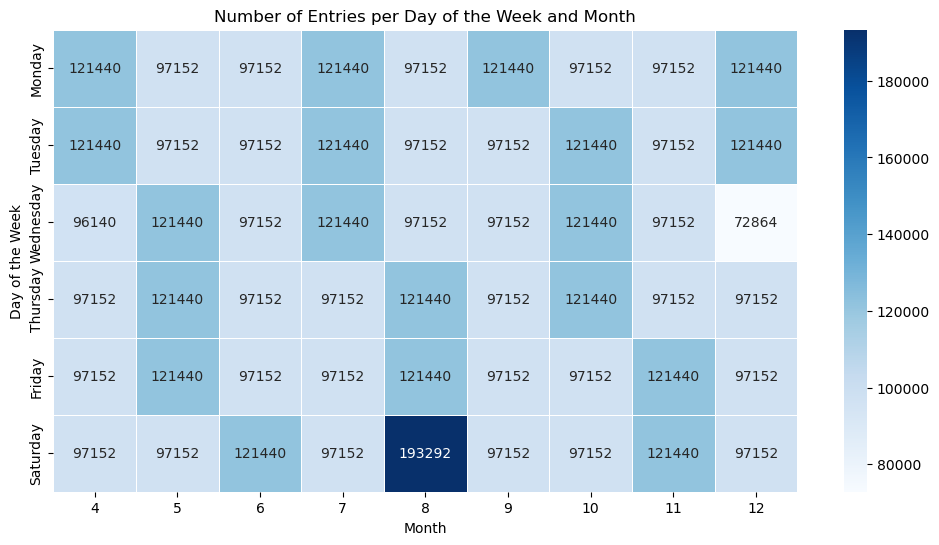

In [20]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

# Count occurrences per (Month, DayOfWeek)
entries_count = df_control_long.groupby(['DayOfWeek', 'Month']).size().unstack()
entries_count = entries_count.reindex(day_order)


plt.figure(figsize=(12,6))
sns.heatmap(entries_count, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.xlabel("Month")
plt.ylabel("Day of the Week")
plt.title("Number of Entries per Day of the Week and Month")
plt.show()



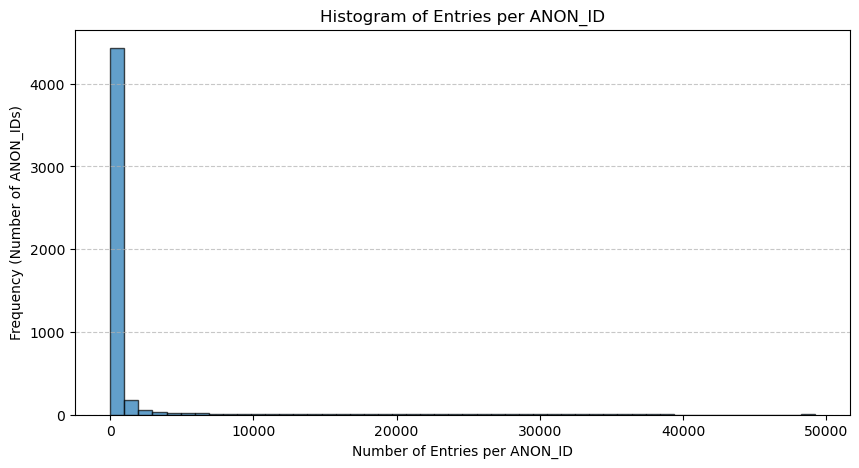

In [21]:
# Count the number of entries per ID
ID_entry_counts = df_control_long.groupby('ELEC_KWH').size()

# Plot histogram
plt.figure(figsize=(10,5))
plt.hist(ID_entry_counts, bins=50, edgecolor='black', alpha=0.7)

# Formatting the plot
plt.xlabel("Number of Entries per ID")
plt.ylabel("Frequency (Number of IDs)")
plt.title("Histogram of Entries per ID")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


## Preprocessing

Making IDs for households and a dictionary matching IDs to hash keys to then drop the hash keys to improve readability

In [254]:
file_name = r"/socioEcodata.csv"
csv_path = fin_path + file_name
df_socio = pd.read_csv(csv_path)
df_socio['ID'] = range(1,len(df_socio) + 1) # make IDs
id_dict = df_socio.set_index('HASH_KEY')['ID'].to_dict() # make dictionary with ID-hash key pairs 
df_socio = df_socio.drop(columns="HASH_KEY") # drop hash keys from table 

In [257]:
len(id_dict)

1138

In [261]:
# df_control = df_control.rename(columns=id_dict)

def data_with_socio(df, dict):
    columns_to_keep = [col for col in df.columns if col in dict]
    return df[columns_to_keep]

control_subset = data_with_socio(df_control, list(id_dict.keys())).rename(columns=id_dict)
int_subset = data_with_socio(df_int, list(id_dict.keys())).rename(columns=id_dict)

In [33]:
# functions from first_checkpoint.ipynb script
# can be edited; less data -> less classes all around 
# from last meeting: different day classes beyond maybe just weekend vs weekday is not feasible 
# further: paper with day and month class breakdowns used all typed of consumers, not just households 
def get_day_class(day):
    if day == 0:  # Monday
        return 1
    elif day in [1, 2, 3]:  # Tuesday, Wednesday, Thursday
        return 2
    elif day == 4:  # Friday
        return 3
    elif day == 5:  # Saturday
        return 4
    elif day == 6:  # Sunday
        return 5

def get_month_class(month):
    if month in [12, 1, 2]:  # Dec, Jan, Feb
        return 1
    elif month == 3:  # March
        return 2
    elif month in [4, 5]:  # April, May
        return 3
    elif month in [6, 7, 9]:  # June, July, September
        return 4
    elif month == 8:  # August
        return 5
    elif month == 10:  # October
        return 6
    elif month == 11:  # November
        return 7


In [66]:

def flash_filter(df, column_mapping):
    """
    Transform a dataframe by:
    a) Renaming columns using the provided mapping dictionary
    b) Dropping columns that are not in the mapping dictionary
    c) Dropping columns with any NA/NaN values
    
    Parameters:
    df (pandas.DataFrame): The original dataframe with hash key columns
    column_mapping (dict): Dictionary mapping hash keys to column IDs
    
    Returns:
    pandas.DataFrame: The transformed dataframe
    """

    # Step 1: Keep only columns that are in the mapping dictionary
    columns_to_keep = [col for col in df.columns if col in column_mapping]
    df_filtered = df[columns_to_keep].copy()
    
    # Step 2: Rename the columns using the mapping dictionary
    rename_dict = {col: column_mapping[col] for col in columns_to_keep}
    df_renamed = df_filtered.rename(columns=rename_dict)
    
    # Step 3: Drop columns with any NA or NaN values
    # This gets columns that have at least one NA
    """columns_with_na = df_renamed.columns[df_renamed.isna().any()].tolist()
    df_final = df_renamed.drop(columns=columns_with_na)"""
    
    df_renamed.insert(0, 'Time', df['Unnamed: 0'])

    return df_renamed

# Example usage:
# Assuming df is your original dataframe and column_mapping is your dictionary
# column_mapping = {'hash_key1': 'column_id1', 'hash_key2': 'column_id2', ...}
# transformed_df = transform_dataset(df, column_mapping)



In [89]:
flash_filter = flash_filter(df_control, id_dict)
flash_filter['Time'] = pd.to_datetime(flash_filter['Time'])

In [57]:
"""
for i in flash.columns:
    if type(i) == 'str' and len(i) > 10:
        flash.drop(columns=i)
    if np.isnan(flash[i]).sum() > 0:
        flash.drop(columns=i)
# cleaned = cleaned.drop(columns='Time')
"""


In [90]:
flash_long = pd.melt(flash_filter, id_vars='Time', var_name='ID', value_name='kWh')

# adding HH interval
hh = (flash_long['Time'].dt.hour * 2 + (flash_long['Time'].dt.minute >= 30).astype(int))
flash_long.insert(3,'HH',hh)


"""
Month, Day Class, and Month Class

# adding month
month = flash['Time'].dt.month
flash.insert(4,'Month',month)
# adding day class
day_class = flash['Time'].dt.weekday.apply(get_day_class)
flash.insert(5, 'Day Class', day_class)
# adding month class
month_class = flash['Time'].dt.month.apply(get_month_class)
flash.insert(6, 'Month Class', month_class)
"""


"\nMonth, Day Class, and Month Class\n\n# adding month\nmonth = flash['Time'].dt.month\nflash.insert(4,'Month',month)\n# adding day class\nday_class = flash['Time'].dt.weekday.apply(get_day_class)\nflash.insert(5, 'Day Class', day_class)\n# adding month class\nmonth_class = flash['Time'].dt.month.apply(get_month_class)\nflash.insert(6, 'Month Class', month_class)\n"

In [102]:
# flash.pivot(index='ID', columns='HH', values='kWh')
# df_pivot = df_filtered_dict[df_name].pivot(index='ID', columns='HH', values='kWh')
flash = flash_long.groupby(['ID', 'HH'])['kWh'].mean().reset_index()
flash = flash.pivot(index='ID', columns='HH', values='kWh')

flash.columns = [f'HH_{int(col):02d}' for col in flash.columns]
flash.reset_index(inplace=True)


In [103]:
flash

,ID,HH_00,HH_01,HH_02,HH_03,HH_04,HH_05,HH_06,HH_07,HH_08,...,HH_38,HH_39,HH_40,HH_41,HH_42,HH_43,HH_44,HH_45,HH_46,HH_47
0,1,0.094363,0.078515,0.069464,0.059595,0.050608,0.051346,0.048309,0.047966,0.043591,...,0.202565,0.181219,0.147093,0.165333,0.178772,0.172751,0.131637,0.115076,0.105190,0.100578
1,3,0.041013,0.036612,0.036345,0.035378,0.034672,0.034937,0.036165,0.037131,0.034647,...,0.099349,0.091109,0.095929,0.100361,0.101294,0.101239,0.100155,0.089571,0.065782,0.052718
2,5,0.148582,0.145346,0.134370,0.134609,0.131357,0.129987,0.124966,0.127462,0.125605,...,0.606378,0.494181,0.431975,0.422576,0.413471,0.404945,0.292962,0.242866,0.242101,0.189689
3,6,0.078407,0.079475,0.091237,0.085975,0.057962,0.054975,0.056111,0.055047,0.053613,...,0.310864,0.189585,0.179373,0.181229,0.171521,0.157360,0.151564,0.182169,0.175919,0.100517
4,8,0.072564,0.068458,0.066511,0.066734,0.065886,0.065291,0.063445,0.065308,0.065477,...,0.180274,0.182827,0.200156,0.187797,0.167996,0.142844,0.143426,0.104679,0.084667,0.094954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,1133,0.074122,0.064903,0.054186,0.047042,0.040384,0.032814,0.027864,0.025384,0.025776,...,0.210975,0.188591,0.180063,0.141517,0.106709,0.099776,0.100072,0.096080,0.085640,0.081257
483,1134,0.117131,0.115473,0.081899,0.095374,0.102502,0.103416,0.125844,0.173933,0.175286,...,0.296445,0.222130,0.211315,0.139567,0.086340,0.049550,0.061870,0.051945,0.102350,0.091193
484,1136,0.160696,0.147937,0.143819,0.139193,0.137769,0.136176,0.132570,0.127370,0.126672,...,0.324508,0.315714,0.329861,0.324227,0.293609,0.257685,0.224244,0.200996,0.195613,0.178508
485,1137,0.077574,0.071123,0.072634,0.071238,0.068345,0.070817,0.074073,0.067621,0.069519,...,0.514826,0.411404,0.286098,0.218511,0.197923,0.180557,0.177281,0.164489,0.137149,0.108323


# PCA + K-Means

Tracking and plotting PCs

Final Cluster Summary Table (PCA-space vs. Reconstructed Features):


,Cluster,PCA_0,PCA_1,PCA_2,PCA_3,Daily_Avg,Daily_Std
0,0 PCA-space Avg,-3.214912,0.262595,-0.073959,-0.042923,0.108903,0.048025
1,1 PCA-space Avg,2.373449,-0.739789,-0.258398,1.930806,0.220367,0.113455
2,2 PCA-space Avg,17.488343,-2.139238,-1.613350,-0.575020,0.500194,0.157192
3,3 PCA-space Avg,9.507949,1.376279,5.058776,0.841302,0.361839,0.188943
4,4 PCA-space Avg,2.495308,-0.890527,0.036990,-0.980339,0.216800,0.104039
5,5 PCA-space Avg,3.369764,3.951876,-3.949251,3.711987,0.247467,0.251615
6,6 PCA-space Avg,19.968689,24.865904,-5.986075,-1.807746,0.585852,0.461053
7,0 Reconstructed Avg,-3.214912,0.262595,-0.073959,-0.042923,0.108903,0.048025
8,1 Reconstructed Avg,2.373449,-0.739789,-0.258398,1.930806,0.220367,0.113455
9,2 Reconstructed Avg,17.488343,-2.139238,-1.613350,-0.575020,0.500194,0.157192


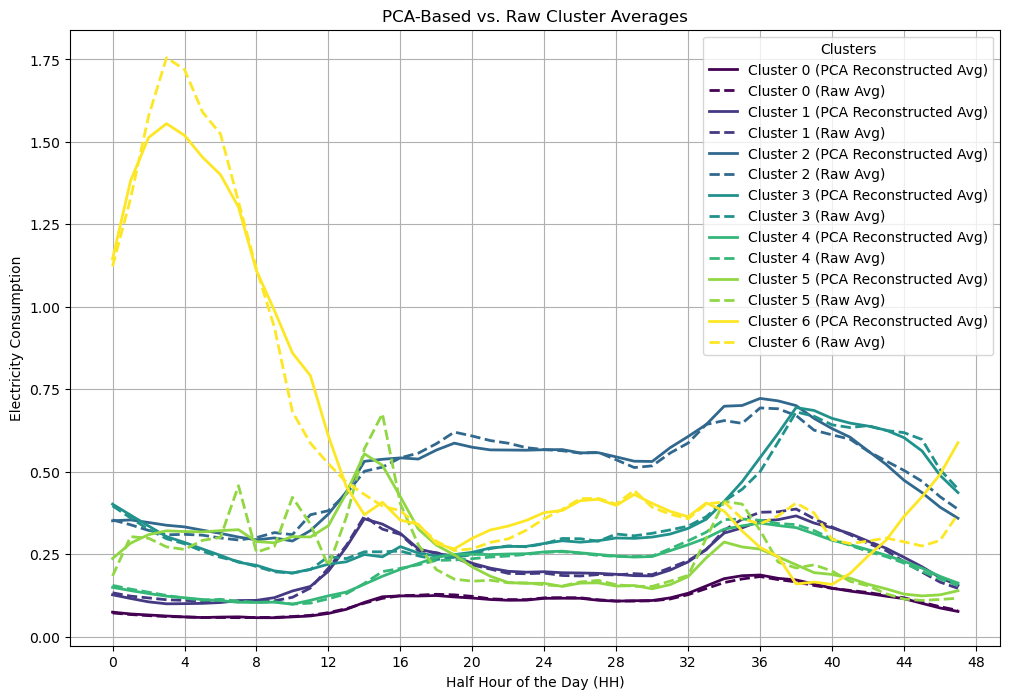

In [107]:
# 1) Define parameters
# ------------------------------------------------------------------------------
pca_components = 4                  
optimal_clusters = 7                

# 2) Compute daily stats 
# ------------------------------------------------------------------------------
data_24 = flash.drop(columns=["ID"])  
daily_avg = data_24.mean(axis=1).values  # shape (n_samples,)
daily_std = data_24.std(axis=1).values   # shape (n_samples,)
IDs = flash["ID"].values
data_24_values = data_24.values.astype(np.float64)  # shape (n_samples, 48)
# Turn daily_avg and daily_std into columns so we can horizontally stack them
daily_avg_col = daily_avg.reshape(-1, 1)  # shape (n_samples, 1)
daily_std_col = daily_std.reshape(-1, 1)  # shape (n_samples, 1)

# 3) Scale the raw half-hour data, then apply PCA
# ------------------------------------------------------------------------------
scaler_raw = StandardScaler()
data_24_scaled = scaler_raw.fit_transform(data_24_values)  # shape (n_samples, 48)
pca = PCA(n_components=pca_components, random_state=42)
pca_scores = pca.fit_transform(data_24_scaled)             # shape (n_samples, pca_components)

# 4) Combine PCA components + daily stats
# ------------------------------------------------------------------------------
combined_features = np.hstack([
    pca_scores,       # PCA columns
    daily_avg_col, 
    daily_std_col
])  # shape (n_samples, pca_components + 2)

# Optionally scale again (the combined feature set)
scaler_combined = StandardScaler()
combined_features_scaled = scaler_combined.fit_transform(combined_features)

# 5) K-Means Clustering on the combined features
# ------------------------------------------------------------------------------
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(combined_features_scaled)

# 6) Build a DataFrame of results and compute cluster means (raw PCA-scores)
# ------------------------------------------------------------------------------
pca_columns = [f'PCA_{i}' for i in range(pca_components)]
stat_columns = ['Daily_Avg', 'Daily_Std']
all_columns = pca_columns + stat_columns

pca_df = pd.DataFrame(
    np.column_stack([pca_scores, daily_avg, daily_std]),
    columns=all_columns
)
pca_df["ID"] = IDs
pca_df["Cluster"] = clusters

# Compute cluster-level means in PCA-space + daily stats
cluster_feature_means = (
    pca_df.groupby("Cluster")[all_columns].mean().reset_index()
)
cluster_feature_means["Cluster"] = cluster_feature_means["Cluster"].astype(str) + " PCA-space Avg"

# 7) Inverse PCA to approximate the original load curves
# ------------------------------------------------------------------------------
reconstructed_scaled = pca.inverse_transform(pca_scores)   # shape (n_samples, 48)
reconstructed_data = scaler_raw.inverse_transform(reconstructed_scaled)  
reconstructed_data = np.clip(reconstructed_data, a_min=0, a_max=None)  # ensure non-negative !!!

# Put reconstruction into a DataFrame
reconstructed_df = pd.DataFrame(
    reconstructed_data, 
    columns=[f'HH_{i:02d}' for i in range(data_24.shape[1])]
)
reconstructed_df["ID"] = IDs
reconstructed_df["Cluster"] = clusters


# 8) Merge for analyzing reconstructed vs. raw in the same pipeline
# ------------------------------------------------------------------------------
pca_df_no_cluster = pca_df.drop(columns="Cluster")
reconstructed_merged = reconstructed_df.merge(
    pca_df_no_cluster, 
    on="ID", 
    how="left"
)

# 9) Compute cluster-level means (reconstructed)
existing_cols = [c for c in all_columns if c in reconstructed_merged.columns]
cluster_recon_means = (
    reconstructed_merged
    .groupby("Cluster")[existing_cols]
    .mean()
    .reset_index()
)
cluster_recon_means["Cluster"] = cluster_recon_means["Cluster"].astype(str) + " Reconstructed Avg"

# Create final summary table
cluster_summary_table = pd.concat([cluster_feature_means, cluster_recon_means], axis=0).reset_index(drop=True)
styled_table = cluster_summary_table.style.background_gradient(cmap="Blues")

print("Final Cluster Summary Table (PCA-space vs. Reconstructed Features):")
display(styled_table)

# 10) Plot Reconstructed vs. Raw cluster averages 
# ------------------------------------------------------------------------------
# A) Reconstructed-based average
df_long_recon = reconstructed_df.melt(
    id_vars=["ID", "Cluster"], 
    var_name="HH", 
    value_name="kWh"
)
# only keep numeric part from HH_XX
df_long_recon["HH"] = df_long_recon["HH"].str.extract(r'(\d+)').astype(int)
cluster_avg_recon = (
    df_long_recon.groupby(["Cluster", "HH"])["kWh"]
    .mean()
    .reset_index()
    .rename(columns={"kWh": "Reconstructed_Avg_kWh"})
)

# B) Raw average
df_merged_raw = flash.merge(pca_df[["ID", "Cluster"]], on="ID", how="left")
df_long_raw = df_merged_raw.melt(id_vars=["ID", "Cluster"], var_name="HH", value_name="kWh")
df_long_raw["HH"] = df_long_raw["HH"].str.extract(r'(\d+)').astype(int)
cluster_avg_raw = (
    df_long_raw.groupby(["Cluster", "HH"])["kWh"]
    .mean()
    .reset_index()
    .rename(columns={"kWh": "Raw_Avg_kWh"})
)

# C) Plot
plt.figure(figsize=(12, 8))
cluster_ids = sorted(cluster_avg_recon["Cluster"].unique())
colors = plt.cm.viridis(np.linspace(0, 1, len(cluster_ids)))

for i, cid in enumerate(cluster_ids):
    # Reconstructed-based
    recon_data = cluster_avg_recon[cluster_avg_recon["Cluster"] == cid]
    # Raw-based
    raw_data = cluster_avg_raw[cluster_avg_raw["Cluster"] == cid]

    plt.plot(
        recon_data["HH"], recon_data["Reconstructed_Avg_kWh"],
        color=colors[i], linewidth=2, label=f'Cluster {cid} (PCA Reconstructed Avg)'
    )
    plt.plot(
        raw_data["HH"], raw_data["Raw_Avg_kWh"],
        color=colors[i], linestyle='--', linewidth=2, label=f'Cluster {cid} (Raw Avg)'
    )

plt.title("PCA-Based vs. Raw Cluster Averages")
plt.xlabel("Half Hour of the Day (HH)")
plt.ylabel("Electricity Consumption")
plt.xticks(range(0, data_24.shape[1]+1, 4))
plt.legend(title="Clusters", loc="best")
plt.grid(True)
plt.show()


In [122]:
flash

,ID,Cluster,HH_00,HH_01,HH_02,HH_03,HH_04,HH_05,HH_06,HH_07,...,HH_38,HH_39,HH_40,HH_41,HH_42,HH_43,HH_44,HH_45,HH_46,HH_47
0,1,0,0.094363,0.078515,0.069464,0.059595,0.050608,0.051346,0.048309,0.047966,...,0.202565,0.181219,0.147093,0.165333,0.178772,0.172751,0.131637,0.115076,0.105190,0.100578
1,3,0,0.041013,0.036612,0.036345,0.035378,0.034672,0.034937,0.036165,0.037131,...,0.099349,0.091109,0.095929,0.100361,0.101294,0.101239,0.100155,0.089571,0.065782,0.052718
2,5,4,0.148582,0.145346,0.134370,0.134609,0.131357,0.129987,0.124966,0.127462,...,0.606378,0.494181,0.431975,0.422576,0.413471,0.404945,0.292962,0.242866,0.242101,0.189689
3,6,0,0.078407,0.079475,0.091237,0.085975,0.057962,0.054975,0.056111,0.055047,...,0.310864,0.189585,0.179373,0.181229,0.171521,0.157360,0.151564,0.182169,0.175919,0.100517
4,8,4,0.072564,0.068458,0.066511,0.066734,0.065886,0.065291,0.063445,0.065308,...,0.180274,0.182827,0.200156,0.187797,0.167996,0.142844,0.143426,0.104679,0.084667,0.094954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,1133,0,0.074122,0.064903,0.054186,0.047042,0.040384,0.032814,0.027864,0.025384,...,0.210975,0.188591,0.180063,0.141517,0.106709,0.099776,0.100072,0.096080,0.085640,0.081257
483,1134,5,0.117131,0.115473,0.081899,0.095374,0.102502,0.103416,0.125844,0.173933,...,0.296445,0.222130,0.211315,0.139567,0.086340,0.049550,0.061870,0.051945,0.102350,0.091193
484,1136,4,0.160696,0.147937,0.143819,0.139193,0.137769,0.136176,0.132570,0.127370,...,0.324508,0.315714,0.329861,0.324227,0.293609,0.257685,0.224244,0.200996,0.195613,0.178508
485,1137,4,0.077574,0.071123,0.072634,0.071238,0.068345,0.070817,0.074073,0.067621,...,0.514826,0.411404,0.286098,0.218511,0.197923,0.180557,0.177281,0.164489,0.137149,0.108323


Cluster headcounts for PCA

In [179]:
cluster_labels = pd.DataFrame({'Cluster' : clusters})
flash_clusters = flash['ID'].to_frame()
flash_clusters['Cluster'] = cluster_labels
flash_clusters['Cluster'].value_counts()

Cluster
0    288
4    106
1     50
3     18
2     18
5      5
6      2
Name: count, dtype: int64

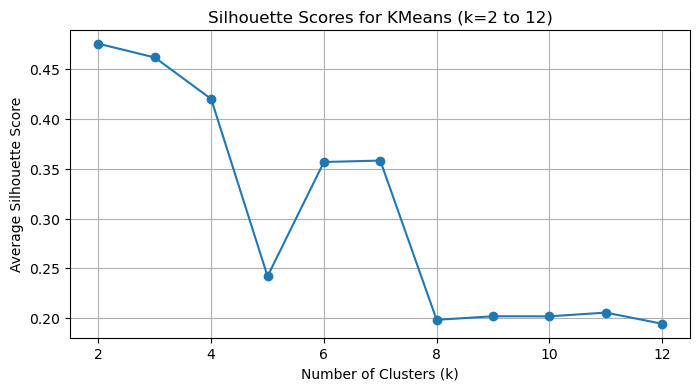

In [106]:

# Suppose X is your *scaled* feature matrix used for clustering,
# e.g. combined_features_scaled_24_comp_tuned from your PCA or FFT approach.

silhouette_scores = []
clusters_range = range(2, 13)  # 2 to 12

for k in clusters_range:
    kmeans = KMeans(n_clusters=k, random_state=42)

    labels = kmeans.fit_predict(combined_features_scaled)
    # Compute average silhouette score for this k
    sil_score = silhouette_score(combined_features_scaled, labels)
    silhouette_scores.append(sil_score)

# Plot the silhouette scores
plt.figure(figsize=(8, 4))
plt.plot(list(clusters_range), silhouette_scores, marker='o')
plt.title("Silhouette Scores for KMeans (k=2 to 12)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Average Silhouette Score")
plt.grid(True)
plt.show()


Most distant IDs in feature space for cluster 1: 506.0, 320.0


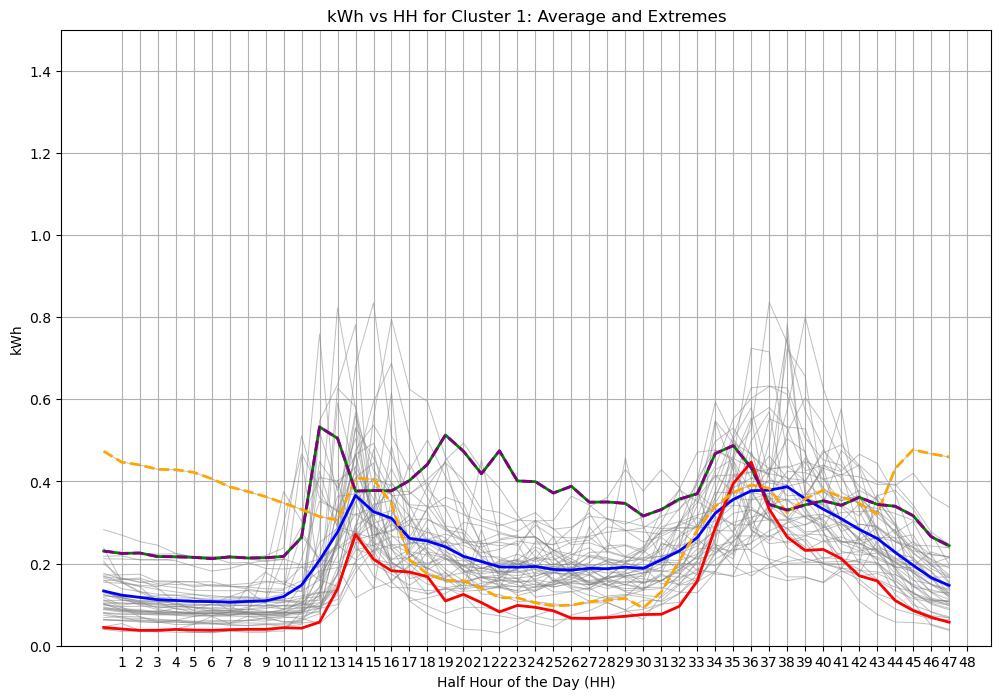

Feature Table for Cluster 1 and Extreme IDs:


,PCA_0,PCA_1,PCA_2,PCA_3,Daily_Avg,Daily_Std
ID,,,,,,
Cluster_Average,2.373449,-0.739789,-0.258398,1.930806,0.220367,0.113455
320,9.362411,-0.853035,-2.757344,0.730866,0.344063,0.092061
257,-2.631579,-0.838231,0.275562,1.788933,0.127562,0.099196
506.0,5.851836,7.191074,1.572392,3.765220,0.301381,0.129016


In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------------
# Let's assume you have a final KMeans model trained on X (scaled features),
# and a DataFrame df_all with columns:
#   ID, HH, kWh, Cluster, and so on
# ---------------------------------------------------------------------------
feature_cols = all_columns
df_features = pca_df
df_long_raw = df_merged_raw.melt(id_vars=["ID", "Cluster"], var_name="HH", value_name="kWh")
df_long_raw["HH"] = df_long_raw["HH"].str.extract(r'(\d+)').astype(int)
df_all = df_long_raw

target_cluster = 1  # the cluster you want to inspect

# ---------------------------
# A) Filter data for the target cluster
# ---------------------------
cluster_data = df_all[df_all['Cluster'] == target_cluster].copy()

# Group by ID and HH to get average consumption per half-hour per ID.
cluster_avg_by_anon = (
    cluster_data.groupby(['ID', 'HH'])['kWh']
    .mean()
    .reset_index()
)

# ---------------------------
# B) Compute the cluster's average load curve
# ---------------------------
cluster_avg = (
    cluster_avg_by_anon
    .groupby('HH')['kWh']
    .mean()
    .reset_index()
    .rename(columns={'kWh': 'Cluster_Avg_kWh'})
)

# Merge the cluster average back with the individual ID data
cluster_data_merged = cluster_data.merge(cluster_avg, on='HH', how='left')

# ---------------------------
# C) Identify extremes based on difference from cluster average
# ---------------------------
# "Difference" = kWh - Cluster_Avg_kWh for each half hour
cluster_data_merged['Difference'] = cluster_data_merged['kWh'] - cluster_data_merged['Cluster_Avg_kWh']

# Calculate the mean difference PER ID
anon_diff = (
    cluster_data_merged.groupby('ID')['Difference']
    .mean()
    .reset_index()
    .rename(columns={'Difference': 'Mean_Difference'})
)

most_positive_anon = anon_diff.loc[anon_diff['Mean_Difference'].idxmax(), 'ID']
most_negative_anon = anon_diff.loc[anon_diff['Mean_Difference'].idxmin(), 'ID']

# ---------------------------
# D) Identify extremes based on distance to cluster centroid in feature space
# ---------------------------
# 1) We need the cluster centroid in scaled space.
#    We'll retrieve the scaled centroid from the trained KMeans model:
centroids_scaled = kmeans.cluster_centers_  # shape (n_clusters, n_features)
target_centroid_scaled = centroids_scaled[target_cluster]  # shape (n_features,)

# 2) For each ID in this cluster, compute the distance from that centroid in scaled space.
#    That means we need the scaled features for each ID. 
#    Suppose you have a DataFrame "df_features" with columns: [ID] + feature columns + [Cluster]

#    and "X" is the scaled matrix. We'll do a merge or map.
df_cluster_features = df_features[df_features['Cluster'] == target_cluster].copy()

# Let's extract only the feature columns that match X's structure. 

# (Assume "feature_cols" is the list of columns used for KMeans.)
feature_array = df_cluster_features[feature_cols].values  # shape (samples_in_cluster, n_features)

# Distances in scaled space (Euclidean)
distances = np.linalg.norm(feature_array - target_centroid_scaled, axis=1)

df_cluster_features['Dist_Centroid'] = distances

# Let's pick the two IDs with largest distances:
idx_sort = df_cluster_features['Dist_Centroid'].argsort()[::-1]  # sort descending
furthest_1 = df_cluster_features.iloc[idx_sort.iloc[0]]['ID']
furthest_2 = df_cluster_features.iloc[idx_sort.iloc[1]]['ID']

print(f"Most distant IDs in feature space for cluster {target_cluster}: {furthest_1}, {furthest_2}")

# ---------------------------
# E) Plot all time-series + extremes
# ---------------------------
plt.figure(figsize=(12, 8))

# Plot all time-series in grey
for ID in cluster_avg_by_anon['ID'].unique():
    anon_data = cluster_avg_by_anon[cluster_avg_by_anon['ID'] == ID]
    plt.plot(anon_data['HH'], anon_data['kWh'], color='grey', alpha=0.5, linewidth=0.7)

# Plot the cluster average in blue
plt.plot(
    cluster_avg['HH'], cluster_avg['Cluster_Avg_kWh'],
    color='blue', linewidth=2, label=f'Cluster {target_cluster} Average'
)

# Plot extremes based on difference from cluster average
positive_anon_data = cluster_avg_by_anon[cluster_avg_by_anon['ID'] == most_positive_anon]
negative_anon_data = cluster_avg_by_anon[cluster_avg_by_anon['ID'] == most_negative_anon]

plt.plot(
    positive_anon_data['HH'], positive_anon_data['kWh'],
    color='green', linewidth=2, label=f'Most Positive vs Avg: {most_positive_anon}'
)
plt.plot(
    negative_anon_data['HH'], negative_anon_data['kWh'],
    color='red', linewidth=2, label=f'Most Negative vs Avg: {most_negative_anon}'
)

# Plot extremes based on centroid distance
# (just to visually see them - choose another color scheme)
furthest_anon_1_data = cluster_avg_by_anon[cluster_avg_by_anon['ID'] == furthest_1]
furthest_anon_2_data = cluster_avg_by_anon[cluster_avg_by_anon['ID'] == furthest_2]

plt.plot(
    furthest_anon_1_data['HH'], furthest_anon_1_data['kWh'],
    color='orange', linestyle='--', linewidth=2, 
    label=f'Furthest in Feature Space: {furthest_1}'
)
plt.plot(
    furthest_anon_2_data['HH'], furthest_anon_2_data['kWh'],
    color='purple', linestyle='--', linewidth=2, 
    label=f'Furthest in Feature Space: {furthest_2}'
)

# Plot details
plt.title(f'kWh vs HH for Cluster {target_cluster}: Average and Extremes')
plt.xlabel('Half Hour of the Day (HH)')
plt.ylabel('kWh')
plt.ylim(0,1.5)
plt.xticks(range(1, 49))  # or range(0,48) depending on your HH labels
plt.legend
plt.grid(True)
plt.show()

# ---------------------------
# F) Create a small feature table
# ---------------------------
# We want to compare:
#   - the cluster average (in feature space),
#   - the "most positive" ID,
#   - the "most negative" ID,
#   - the "furthest_1" and "furthest_2" from centroid
#
# For the cluster average in feature space, we can take the mean of feature columns
# specifically for target_cluster. For the 4 unique IDs, we do the same.

unique_ids = [most_positive_anon, most_negative_anon, furthest_1, furthest_2]
# some might coincide if the same ID is "most positive" and also "furthest from centroid"
# A small helper function that returns the row of mean features for the entire cluster
def get_cluster_mean_features(cluster_id):
    subset = df_features[df_features['Cluster'] == cluster_id]
    return subset[feature_cols].mean()

cluster_avg_features = get_cluster_mean_features(target_cluster)

# For each of the extreme IDs, compute mean of the features (or you might do just the single row if they have 1 row)
extreme_features = {}
for a_id in unique_ids:
    subset_id = df_features[df_features['ID'] == a_id]
    if len(subset_id) == 0:
        continue
    ext_mean = subset_id[feature_cols].mean()
    extreme_features[a_id] = ext_mean

# Build a combined DataFrame
table_data = {}
table_data['Cluster_Average'] = cluster_avg_features.to_dict()

for a_id, vals in extreme_features.items():
    table_data[a_id] = vals.to_dict()

table_df = pd.DataFrame(table_data).T
table_df.index.name = 'ID'
print(f"Feature Table for Cluster {target_cluster} and Extreme IDs:")
display(table_df)



Notes: 

- controlConsolide has households that don't have socioeconomic data accompanying them. 
    - Possible Actions: split IDs sets into ones with and without 